In [1]:
using CSV
using DataFrames
using Statistics

In [19]:
df = DataFrame(CSV.File("../Data/ALLvariants_exclSynonymous_Xadj.txt"))

## remove 0 VAF "non-variant" calls (why do these exist?)
df = subset(df, :Gene => g -> g .!= "NA")

function fixArrTypeToFloat64(arr::Vector{<:Any})
    newArr = Vector{Float64}(undef, length(arr))
    if typeof(arr) != Vector{Float64}
        for (i,x) in enumerate(arr)
            try 
                newArr[i] = parse(Float64,x)
            catch
                newArr[i] = 0.
            end
        end
        return newArr
    else return Array
    end
end

df[!,:VAF] .= fixArrTypeToFloat64(df[!,:VAF])

names(df)

16-element Vector{String}:
 "SardID"
 "Gender"
 "Phase"
 "Age"
 "Gene"
 "CHR"
 "START"
 "END"
 "REF"
 "ALT"
 "MUTcount_Xadj"
 "WTcount"
 "TOTALcount"
 "VAF"
 "Type"
 "AAChange.refGene"

In [20]:
function distbin(x_vid::Vector{T} where T<:Real; bins::Int=25, xMin::Real=0, xMax::Real=1., normalized::Bool=true)
    # println("any x<0: ", any(x_vid .< 0))
    # nVars = length(x_vid)
    _xEdges = range(xMin, xMax, length=bins+1)
    dx = _xEdges[2]-_xEdges[1]
    _f = _xEdges[1:end-1] .+ dx/2
    withinRangeBool_vid = (x -> x>=xMin && x<xMax).(x_vid)   #apply thresholds
    nV_f = zeros(Float64, bins)
    for x in x_vid[withinRangeBool_vid]
        k = ((x-xMin)/dx |> floor |> Int) + 1
        nV_f[k] += 1
    end
    # normalized && (nV_f ./= length(x_vid[withinRangeBool_vid])*dx)
    normalized && (nV_f ./= (length(x_vid)*dx))
    return _f, nV_f
end

function dropdupes(arr::Vector{<:Real})
    newArr = eltype(arr)[]
    for el in arr
        el in newArr ? continue : push!(newArr, el)
    end
    return newArr
end
function dropdupes(arr::AbstractVector)
    newArr = eltype(arr)[]
    for el in arr
        el in newArr ? continue : push!(newArr, el)
    end
    return newArr
end
_pid = dropdupes(df[!,:SardID])

length(_pid)

distbin([0.1,0.2,0.3,0.2,0.123123,], bins=3)

(0.16666666666666666:0.3333333333333333:0.8333333333333334, [3.0000000000000004, 0.0, 0.0])

In [21]:
subset(df[!, [:SardID, :Phase, :Age, :Gene, :VAF]], :SardID => id -> id .== 260, :Phase => p -> p .== 1)
subset(
    df[!, [:SardID, :Phase, :Age, :Gene, :VAF]],
    :SardID => id -> id .== 260
)

,SardID,Phase,Age,Gene,VAF
,Int64,Int64,Float64,String7,Float64
1,260,1,61.02,ASXL1,0.0013
2,260,2,64.02,ASXL1,0.0006
3,260,3,67.75,ASXL1,0.0
4,260,4,71.09,ASXL1,0.0007
5,260,5,75.36,ASXL1,0.0143
6,260,1,61.02,PHF6,0.0
7,260,2,64.02,PHF6,0.0
8,260,3,67.75,PHF6,0.00155
9,260,4,71.09,PHF6,0.02915


In [5]:
nVars_pid = [
    subset(df, :SardID => id -> id .== pid, :Phase => p -> p .== 1, :VAF => f->f.>0)[!, :VAF] |> length
    for pid in _pid
];

In [6]:
using CairoMakie

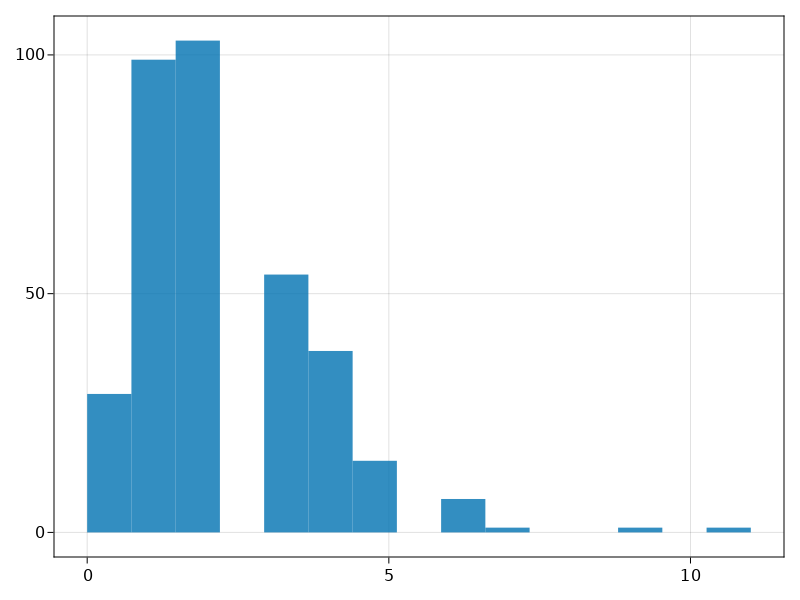

In [7]:
hist(nVars_pid)

Since most quantities vary with age, the first step is to sort the patients by age

In [22]:
function patientPhaseExistence(df::DataFrame, pid::Int, phase::Int)
    if subset(df,
            :SardID => id -> id .== pid,
            :Phase => p -> p .== phase,
        )[!, :Phase] |> length == 0
    return false
    else return true
    end
end

function cloneNumberPID(df::DataFrame, pid::Int, phase::Int, minVAF::Real=0.01)
    !patientPhaseExistence(df, pid, phase) && return nothing
    length(
        subset(df,
            :SardID => id -> id .== pid,
            :Phase => p -> p .== phase,
            :VAF => v -> v .>= minVAF,
        )[!, :VAF]
    )
end

function cloneSizeAvPID(df::DataFrame, pid::Int, phase::Int, minVAF::Real=0.)
    !patientPhaseExistence(df, pid, phase) && return nothing
    f_cid = subset(df,
            :SardID => id -> id .== pid,
            :Phase => p -> p .== phase,
            :VAF => v -> v .>= minVAF,
        )[!, :VAF]
    if length(f_cid) == 0 return nothing
    else return mean(f_cid)
    end
end

function cloneSizesPID(df::DataFrame, pid::Int, phase::Int, minVAF::Real=0.)
    f_cid = subset(df,
            :SardID => id -> id .== pid,
            :Phase => p -> p .== phase,
            :VAF => v -> v .>= minVAF,
        )[!, :VAF]
    return f_cid
end

cloneSizesPID (generic function with 2 methods)

In [23]:
fBins = 10
ageBinSize = 5
_ageBinEdges = 54.5:ageBinSize:106
_t = _ageBinEdges[1:end-1] .+ (_ageBinEdges[2]-_ageBinEdges[1])/2
nAgeBins = length(_ageBinEdges) - 1

fDist_T_F = Vector{Vector{Float64}}(undef, nAgeBins)
nClonesAv_t = Vector{Float64}(undef, nAgeBins)
fAv_t = Vector{Float64}(undef, nAgeBins)
_f = Vector{Float64}(undef, fBins)
for i in 1:nAgeBins
    ageL = _ageBinEdges[i]
    ageR = _ageBinEdges[i+1]
    nClones_did = Float64[]
    f_cid = Float64[]
    fAv_did = Float64[]

    dfBin = subset(df,
        :Age => a -> (a .>= ageL) .& (a .< ageR)
    )
    _pidBin = dropdupes(dfBin[!, :SardID])
    for pid in _pidBin
        for phase in 1:5
            n = cloneNumberPID(dfBin, pid, phase, 0)
            fAv = cloneSizeAvPID(dfBin, pid, phase, 0.005)
            !isnothing(n) && append!(nClones_did, n)
            !isnothing(fAv) && append!(fAv_did, fAv)
            append!(f_cid, cloneSizesPID(dfBin, pid, phase, 0))
        end
    end
    _f, fDist_f = distbin(f_cid; bins=fBins, xMin=0, xMax=0.2, normalized=true)
    nClonesAv_t[i] = mean(nClones_did)
    fAv_t[i] = mean(fAv_did)
    fDist_T_F[i] = fDist_f
end

nClonesAv_t

10-element Vector{Float64}:
 2.272727272727273
 2.6634615384615383
 2.581818181818182
 2.747826086956522
 2.9373219373219372
 2.984
 3.195876288659794
 3.5357142857142856
 3.5
 4.75

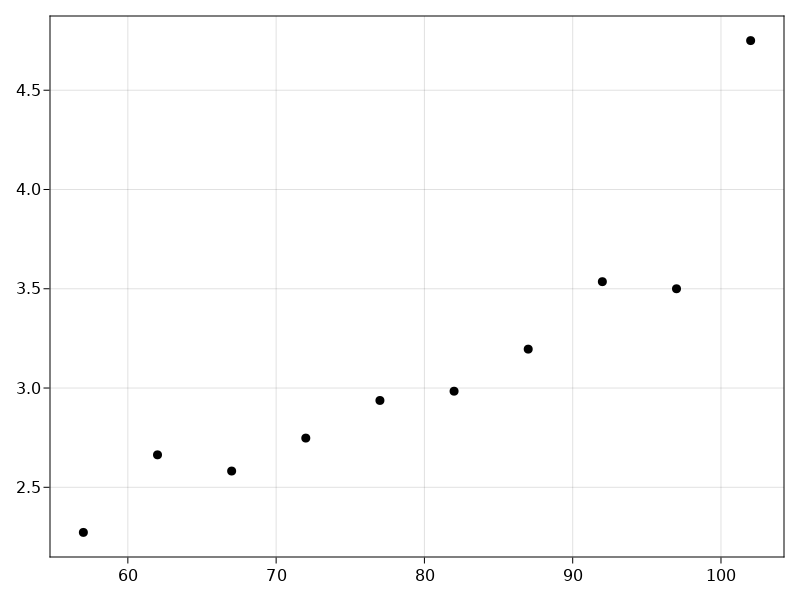

In [10]:
plot(_t, nClonesAv_t)

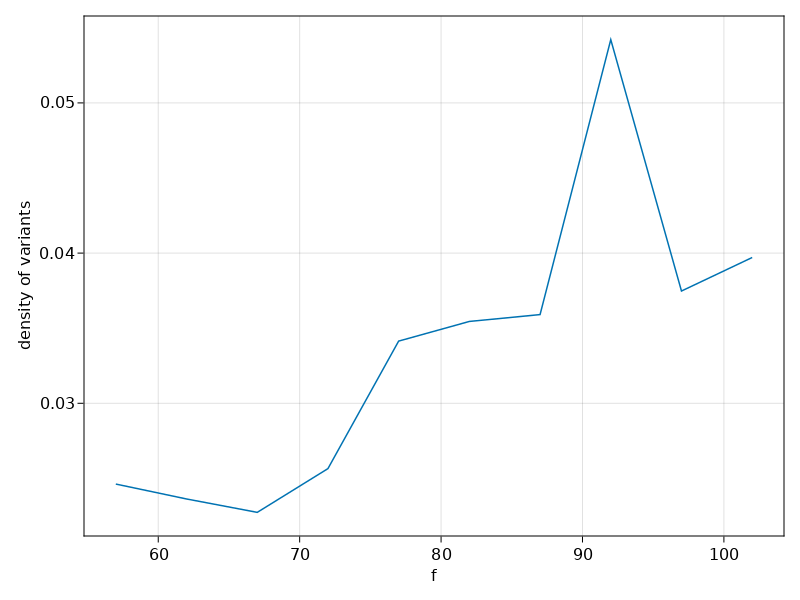

In [9]:
fig = Figure()
Axis(
    fig[1,1],
    xlabel="f",
    ylabel="density of variants",
)

lines!(_t, fAv_t)
# xlims!(0,0.3)
display(fig)

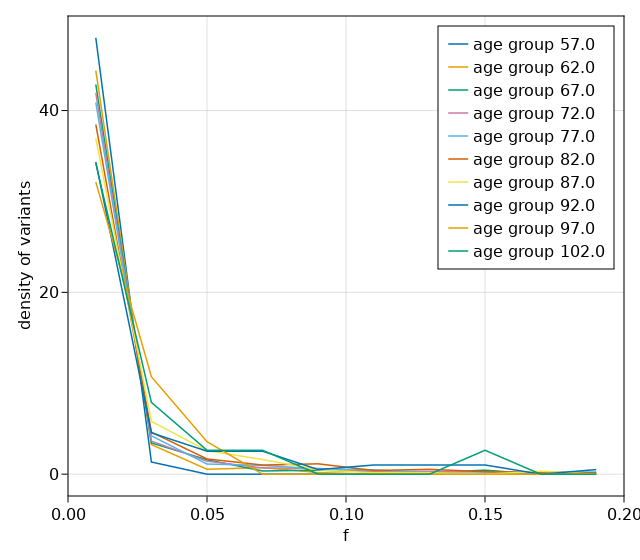

In [29]:
fig = Figure(
    resolution=(0.8*800,0.8*700),

    )
Axis(
    fig[1,1],
    xlabel="f",
    ylabel="density of variants",
)
for t in 1:nAgeBins
    lines!(_f, fDist_T_F[t], label="age group "*string(_t[t]))
end
xlims!(0,0.2)
axislegend()
display(fig)

In [11]:
_gene = dropdupes(df[!,:Gene])

53-element Vector{String7}:
 "ASXL1"
 "BCOR"
 "BCORL1"
 "BRAF"
 "BRCC3"
 "CALR"
 "CBL"
 "CEBPA"
 "CREBBP"
 "CSF3R"
 "CTCF"
 "CUX1"
 "DNMT3A"
 ⋮
 "SF3B1"
 "SMC1A"
 "SMC3"
 "SRSF2"
 "STAG2"
 "STAT3"
 "TET2"
 "TP53"
 "U2AF1"
 "U2AF2"
 "WT1"
 "ZRSR2"

In [12]:
function fOverTimeGenePID(df::DataFrame, gene::AbstractString, pid::Int)
    f_t = subset(df,
            :Gene => g -> g.== gene,
            :SardID => id -> id .== pid,
        )[!,:VAF]
    _t = subset(df,
            :Gene => g -> g.== gene,
            :SardID => id -> id .== pid,
        )[!,:Age]
    return _t, f_t
end

fOverTimeGenePID (generic function with 1 method)

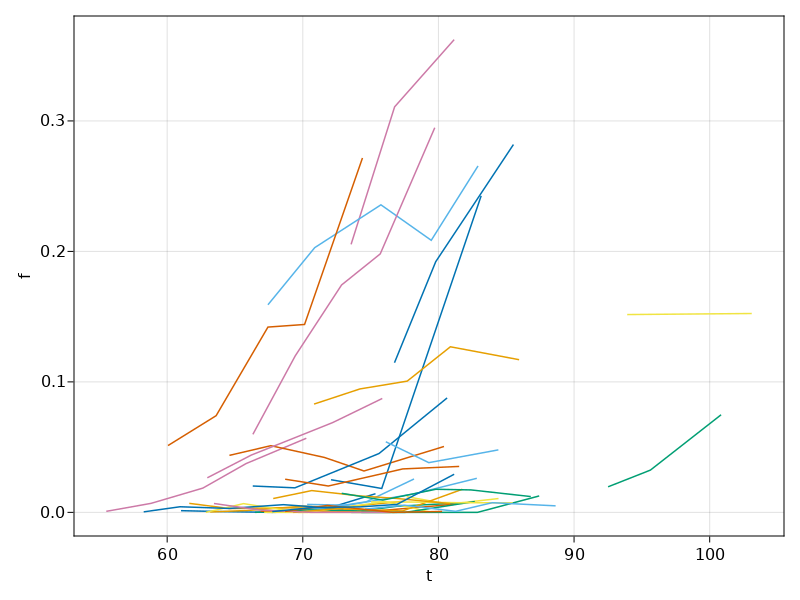

In [13]:
fig = Figure()
Axis(
    fig[1,1],
    xlabel="t",
    ylabel="f",
)


# for (i,gene) in enumerate(_gene)
gene = _gene[1]
for (j, pid) in enumerate(_pid)
    _t, f_t = fOverTimeGenePID(df, gene, pid)
    if length(_t) > 1
        lines!(_t, f_t, label="pid "*string(pid))
    end
end
# end
# axislegend()
display(fig)

In [15]:
df2 = DataFrame(CSV.File("../Data/41586_2022_4785_MOESM9_ESM.csv", header=4, limit=685, ignoreemptyrows=true,
# types=_df2types
))

# fix datatypes of row which could not be parsed correctly (i.e. "NA" in Float row)
function fixArrTypeToFloat64Missing!(df::DataFrame, row::Int)
    if eltype(df[!,row]) != Float64
        newArr = Vector{Union{Float64,Missing}}(undef, size(df,1))
        for (i,x) in enumerate(df[!,row])
            try 
                newArr[i] = parse(Float64,x)
            catch
                newArr[i] = missing
            end
        end
        df[!,row] .= newArr
    end
    return nothing
end

for i in 26:34
    fixArrTypeToFloat64Missing!(df2, i)
end


In [16]:
subset(df2,
    :Gene => g -> g.== _gene[1],
)[!, ["CorrectedAgeAtOnset_Mean","FullEffectMean"]]

,CorrectedAgeAtOnset_Mean,FullEffectMean
,Float64?,Float64
1,31.6366,0.147204
2,9.76756,0.15315
3,0.476322,0.0428089
4,43.8415,0.0784338
5,-0.897409,0.0156111
6,12.6287,0.0777134
7,39.3694,0.143932
8,16.3152,0.0784732
9,-1.0,0.0502188


In [393]:
length(_gene)

53

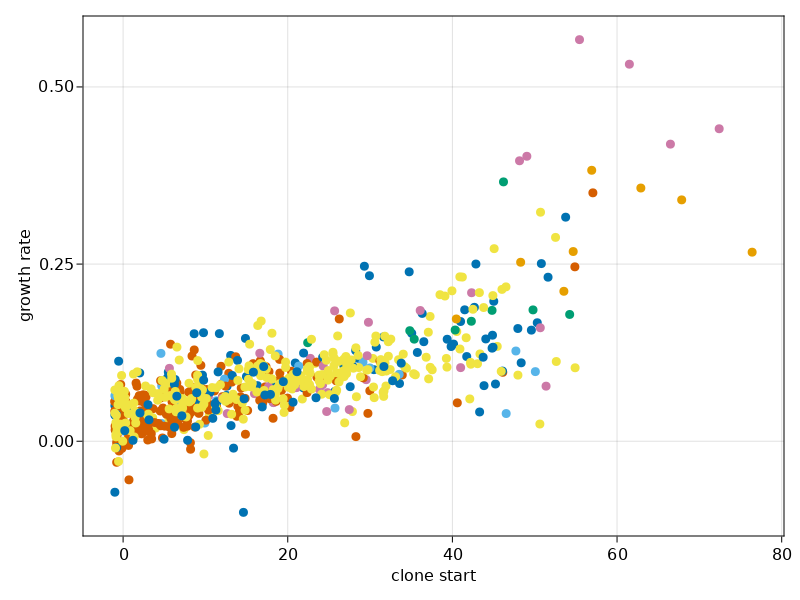

In [19]:
fig = Figure()
Axis(
    fig[1,1],
    xlabel="clone start",
    ylabel="growth rate",
)

for gene in _gene
    scatter!(
        subset(df2,:Gene => g -> g.== gene,)[!,"CorrectedAgeAtOnset_Mean"],
        subset(df2,:Gene => g -> g.== gene,)[!,"FullEffectMean"],
    )
end
# end
# axislegend()
display(fig)

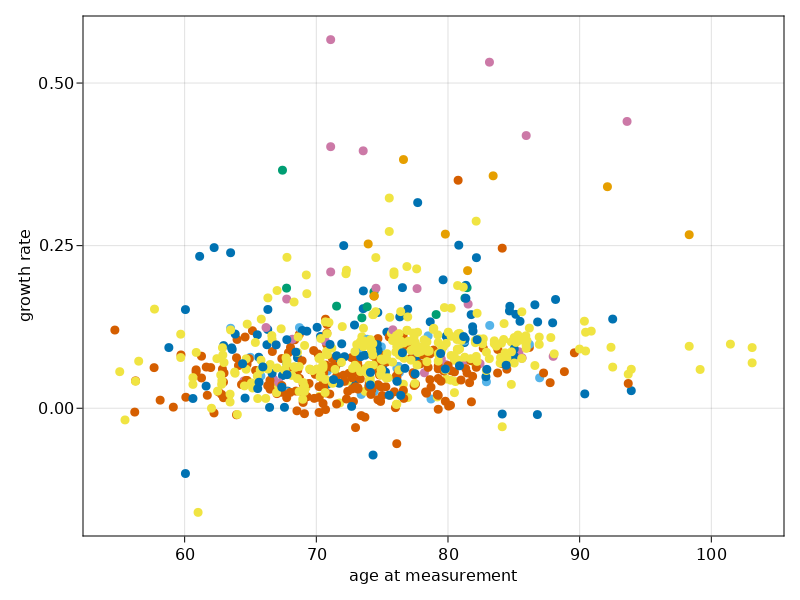

In [20]:
fig = Figure()
Axis(
    fig[1,1],
    xlabel="age at measurement",
    ylabel="growth rate",
)

for gene in _gene
    scatter!(
        subset(df2,:Gene => g -> g.== gene,)[!,"Age At Study Entry"],
        subset(df2,:Gene => g -> g.== gene,)[!,"FullEffectMean"],
    )
end
# end
# axislegend()
display(fig)

In [14]:
gene = _gene[1]
pid = _pid[1]

subset(
    df,
    :Gene => g -> g.== "NA",
    # :SardID => id -> id.== pid,
)[!, [:Gene, :Age, :VAF, :SardID]]

,Gene,Age,VAF,SardID
,String7,Float64,Float64,Int64


In [15]:
using LsqFit, StatsBase

Nf = 1E5
fLogistic(t, t0, r) = 1 / ( 1 + (1 - 1/Nf)/(1/Nf) * exp(-r*(t-t0)) )
fAntiLog(t, t0, r, b0) = b0*Nf / ( Nf + exp(r*(t-t0)) - 1 )
@. modelLogistic(t, p) = fLogistic(t, p[1], p[2])
@. modelAntiLog(t, p) = fAntiLog(t, p[1], p[2], p[3])
p0 = [1., 0.2]
pA0 = [1.,-0.1, 0.05]

λ_vid = Float64[]
t0_vid = Float64[]
age_vid = Float64[]
λ_Gene_Pid = Vector{Vector{Float64}}(undef, length(_gene))
Age_Gene_Pid = Vector{Vector{Float64}}(undef, length(_gene))
vaf_Gene_Pid_Age = Vector{Vector{Vector{Float64}}}(undef, length(_gene))
_age_Gene_Pid = Vector{Vector{Vector{Float64}}}(undef, length(_gene))
@time for (gInd,gene) in enumerate(_gene)
    λ_Gene_Pid[gInd] = Float64[]
    Age_Gene_Pid[gInd] = Float64[]
    vaf_Gene_Pid_Age[gInd] = []
    _age_Gene_Pid[gInd] = []
    _gPid = subset(df,:Gene => g -> g.== gene,)[!,:SardID] |> dropdupes
    for pid in _gPid
        _tG = subset(df,:Gene => g -> g.== gene,:SardID => id -> id.== pid,)[!,:Age]
        if length(_tG)>=3
            vaf_tG = subset(df,:Gene => g -> g.== gene,:SardID => id -> id.== pid,)[!,:VAF]
            corr = corspearman(_tG, vaf_tG)
            fit = let 
                if corr >= 0
                    curve_fit(modelLogistic, _tG, vaf_tG, p0, lower=[-Inf,0])
                else
                    curve_fit(modelAntiLog, _tG, vaf_tG, pA0, lower=[-Inf, -Inf, 0], upper=[Inf, 0, 1])
                end
            end
            # append!(t0_vid, fit.param[1])
            append!(λ_Gene_Pid[gInd], fit.param[2])
            append!(Age_Gene_Pid[gInd], _tG[1])
            push!(vaf_Gene_Pid_Age[gInd], vaf_tG)
            push!(_age_Gene_Pid[gInd], _tG)
        end
    end
end
age_vid = append!(Float64[],[Age_Gene_Pid...]...)
λ_vid = append!(Float64[],[λ_Gene_Pid...]...)
ρS = corspearman(age_vid, λ_vid)

 18.680408 seconds (37.31 M allocations: 1.516 GiB, 4.50% gc time, 81.45% compilation time)


0.048718724299645744

In [16]:
## visually test whether models work and correlation is accurately captured
pA0 = [10.,-0.1, 0.05]
fit1 = curve_fit(
    modelAntiLog,
    _age_Gene_Pid[gInd][1],
    vaf_Gene_Pid_Age[gInd][1],
    pA0, lower=[-Inf, -Inf, 0] ,upper=[Inf, 0, 1]
)
fit2 = curve_fit(
    modelLogistic,
    _age_Gene_Pid[gInd][1],
    vaf_Gene_Pid_Age[gInd][1],
    p0, lower=[-Inf, 0] ,
)
println("anti log λ: ", fit1.param[2])
println("logistic λ: ", fit2.param[2])
println(corspearman(_age_Gene_Pid[gInd][1], vaf_Gene_Pid_Age[gInd][1]))
scatterlines(_age_Gene_Pid[gInd][1], vaf_Gene_Pid_Age[gInd][1])


LoadError: UndefVarError: gInd not defined

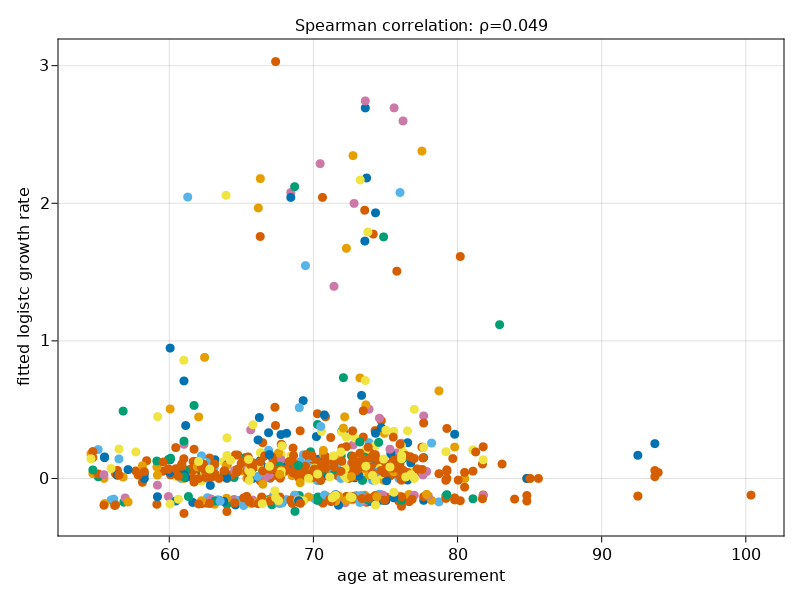

In [17]:
fig5 = Figure()
Axis(
    fig5[1,1],
    xlabel="age at measurement",
    ylabel="fitted logistc growth rate",
    title="Spearman correlation: ρ="*string(round(ρS,digits=3))
)

for i in eachindex(_gene[1:end.!=30])
    scatter!(
        Age_Gene_Pid[i],λ_Gene_Pid[i],
        label=_gene[i],
    )
end
# end
# axislegend()
# println(_gene[ind])
display(fig5)

In [30]:
_indPos = λ_vid .> -5
age_vid = append!(Float64[],[Age_Gene_Pid...]...)
λ_vid = append!(Float64[],[λ_Gene_Pid...]...)
corspearman(age_vid[_indPos], λ_vid[_indPos])
# scatter(age_vid[_indPos], λ_vid[_indPos])

0.048718724299645744

In [31]:
# proportion of increasing variants
sum(λ_vid .> 0)/length(λ_vid)

0.71375

In [32]:
iBin = 1 + floor((67-_tBinEdge[1])/Float64(_tBinEdge.step)) |> Int
vaf_TBin_Vid[18]
λ_vid[8]

LoadError: UndefVarError: _tBinEdge not defined

-0.2


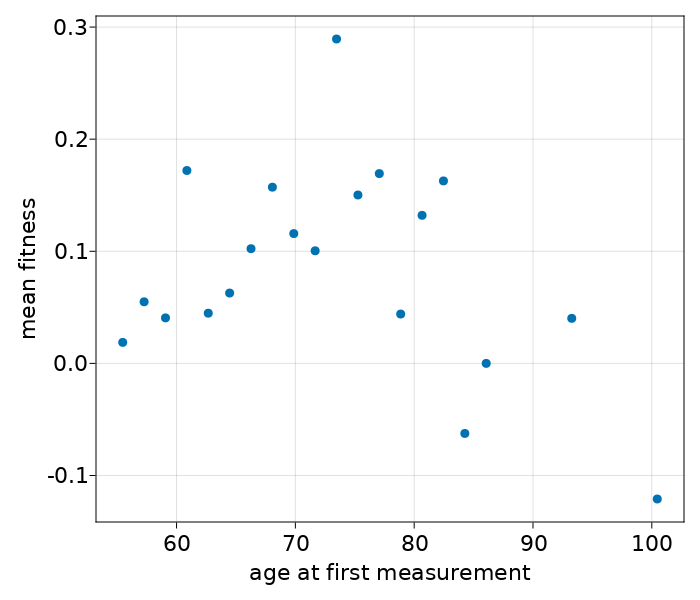

In [37]:
bins = 27
function binVariantsTime(age_vid, λ_vid; bins::Int=21)
    _tBinEdge = range(minimum(age_vid),maximum(age_vid)+1, length=bins)
    _tBin = _tBinEdge[1:end-1] .+ Float64(_tBinEdge.step)/2
    vaf_TBin_Vid = [Float64[] for i in eachindex(_tBin)]
    for (i,t) in enumerate(age_vid)
        iBin = 1 + floor((t-_tBinEdge[1])/Float64(_tBinEdge.step)) |> Int
        append!(vaf_TBin_Vid[iBin], λ_vid[i])
    end
    return _tBinEdge, vaf_TBin_Vid
end

function meanVarSizeTime(age_vid, λ_vid; bins::Int=21)
    _tBinEdge, vaf_TBin_Vid = binVariantsTime(age_vid, λ_vid; bins=bins)
    _tBin = _tBinEdge[1:end-1] .+ Float64(_tBinEdge.step)/2
    vafAv_tBin = Vector{Float64}(undef, length(_tBin))
    for i in eachindex(vaf_TBin_Vid)
        vafAv_tBin[i] = mean(vaf_TBin_Vid[i])
    end
    return _tBin, vafAv_tBin
end

_tBin, vafAv_tBin = meanVarSizeTime(age_vid, λ_vid; bins)
println(corspearman(_tBin[.!isnan.(vafAv_tBin)], vafAv_tBin[.!isnan.(vafAv_tBin)]))
fig1 = Figure(
    resolution=(700,600),
    fontsize=22,
)
Axis(fig1[1,1],
    xlabel="age at first measurement", 
    ylabel="mean fitness",
)
scatter!(_tBin, vafAv_tBin)
display(fig1)

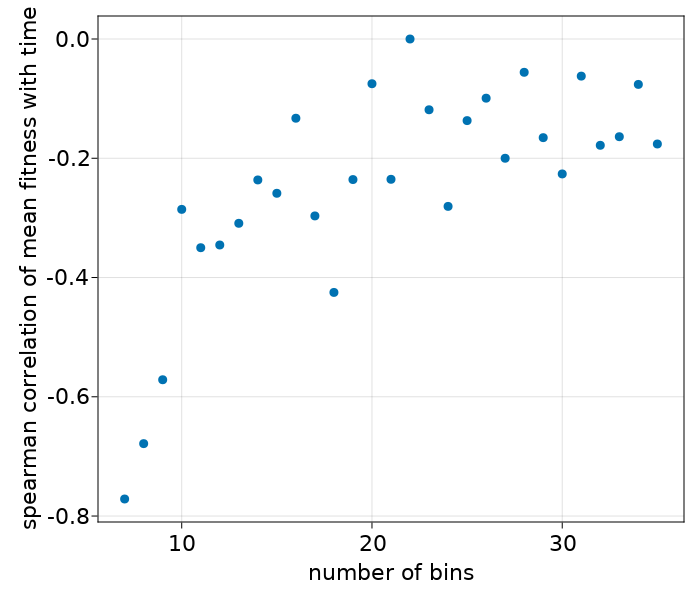

In [38]:
nBins = 7:35
corS_nBins = Vector{Float64}(undef, length(nBins))
for (i,bins) in enumerate(nBins)
    _tBin, vafAv_tBin = meanVarSizeTime(age_vid, λ_vid; bins=bins)
    corS_nBins[i] = corspearman(_tBin[.!isnan.(vafAv_tBin)], vafAv_tBin[.!isnan.(vafAv_tBin)])
end
fig = Figure(
    resolution=(700,600),
    fontsize=22,
)
Axis(
    fig[1,1],
    xlabel="number of bins",
    ylabel="spearman correlation of mean fitness with time"
)
scatter!(nBins, corS_nBins)
display(fig)